# Parkinson Detection

In [2]:
%%capture
!mamba install -- upgrade scikit-learn=1.2.1
!mamba install seaborn --y

In [3]:
!pip install dtreeviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.8/91.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.3/325.3 kB 46.1 MB/s eta 0:00:00


In [4]:
import skillsnetwork
await skillsnetwork.download_dataset("https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX01JCEN/data/parkinsons.data")

Saved as 'parkinsons.data'


In [5]:
import skillsnetwork
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# warning
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

creating helper function for plotting

In [6]:
sns.set(style="whitegrid", color_codes=True)
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = 3*cm.max()/4
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

loading data

In [7]:
data = pd.read_csv('parkinsons.data', sep=',', index_col='name') # assign index column to name 
data.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
name,,,,,,,,,,,,,,,,,,,,,
phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [8]:
print(data.shape)

(195, 23)


creating the correlation matrix

<AxesSubplot:>

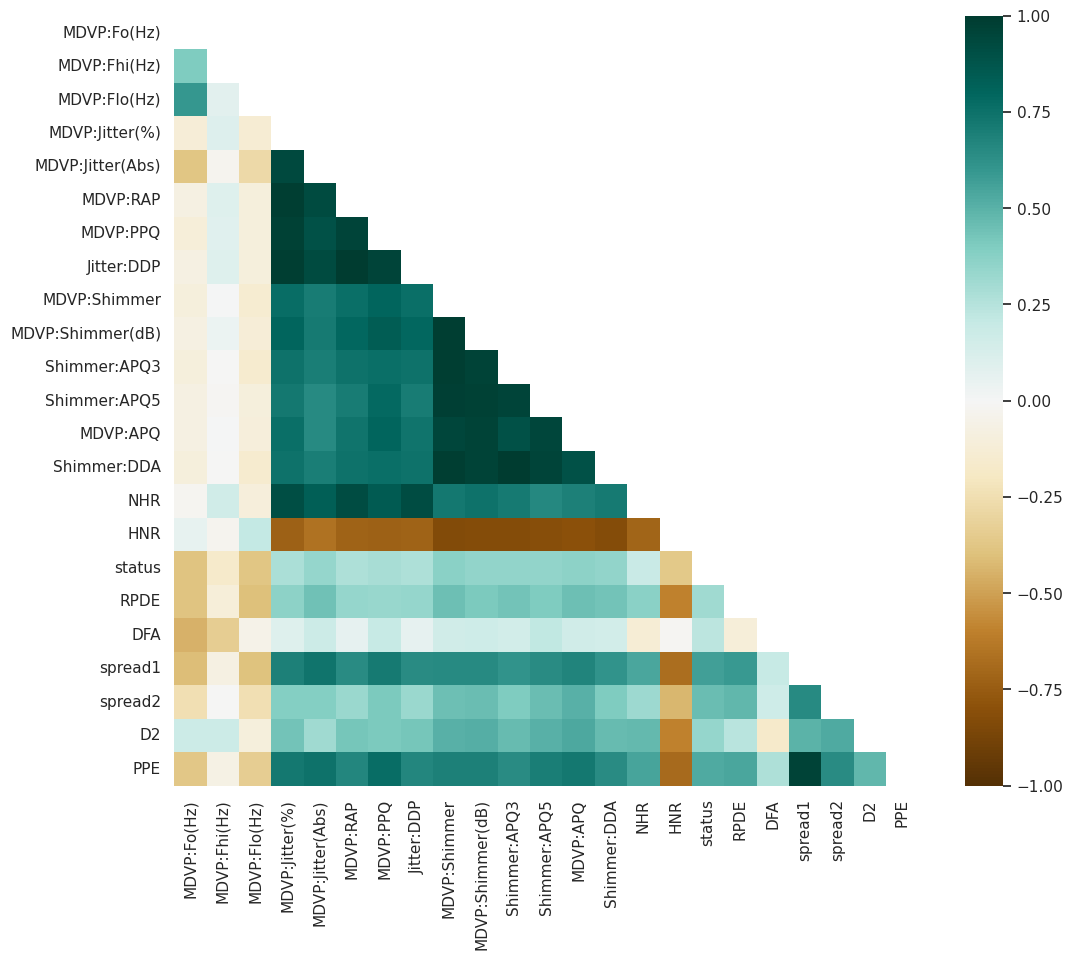

In [9]:
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(data.corr(), dtype=np.bool))
sns.heatmap(data.corr(),vmin=-1, vmax=1,cmap='BrBG', mask=mask)

modify the heat map plot to show correlation variables to the status 

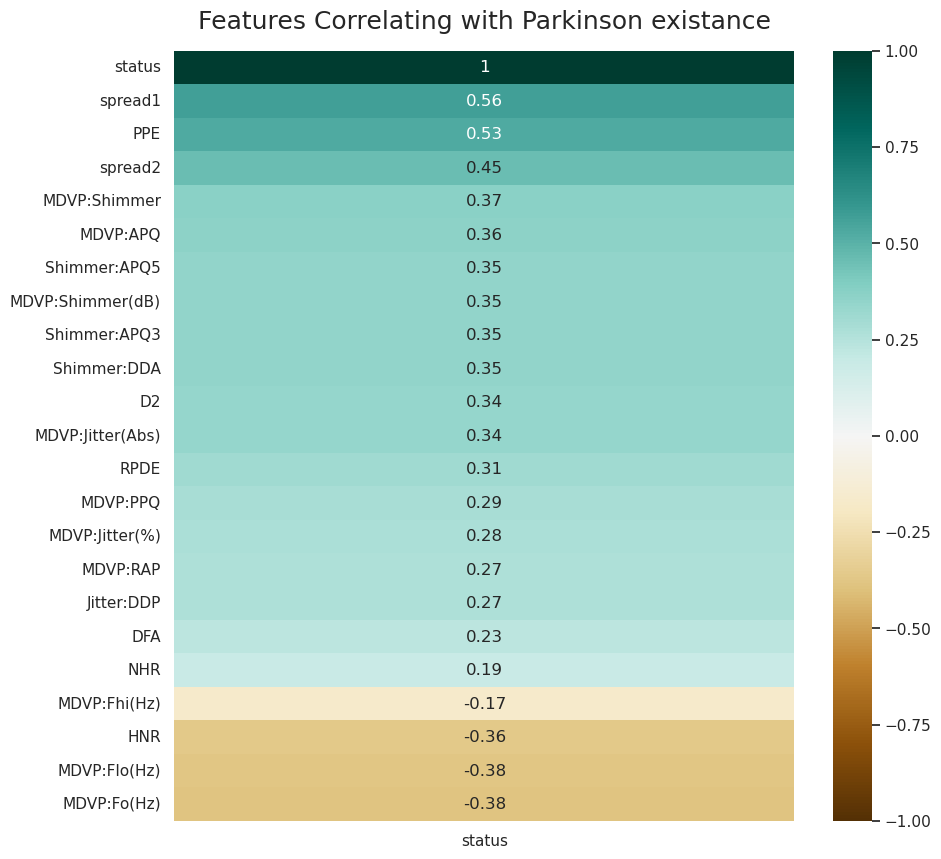

In [10]:
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(data.corr()[['status']].sort_values(by='status', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating with Parkinson existance', fontdict={'fontsize':18}, pad=16);

In [11]:
#drop
X = data.drop('status', axis=1)
X.head()

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),...,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE
name,,,,,,,,,,,,,,,,,,,,,
phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,...,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,...,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,...,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,...,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,...,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335


In [12]:
#parkinsonstatusextraction
y=data['status']
y.head()

name
phon_R01_S01_1    1
phon_R01_S01_2    1
phon_R01_S01_3    1
phon_R01_S01_4    1
phon_R01_S01_5    1
Name: status, dtype: int64

In [13]:
y.value_counts(normalize=True)

1    0.753846
0    0.246154
Name: status, dtype: float64

Distributed Stochastic Neighbor Embedding

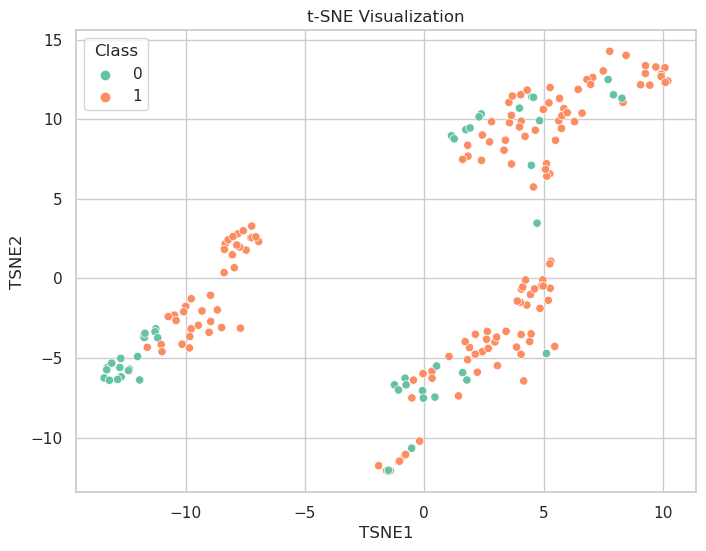

In [14]:
import seaborn as sns
from sklearn.manifold import TSNE

# Apply t-SNE to reduce the dimensions to 2
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X)

# Create a DataFrame with the t-SNE-transformed data and class labels
tsne_df = pd.DataFrame(data=X_tsne, columns=['TSNE1', 'TSNE2'])
tsne_df['Class'] = y.values

# Visualize the data based on class using a scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Class', palette='Set2')
plt.title('t-SNE Visualization')
plt.show()

Data preparation

In [15]:
# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)


# print the shape of train and test data
print("X_train shape: ", X_train.shape)
print("y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

X_train shape:  (136, 22)
y_train shape:  (136,)
X_test shape:  (59, 22)
y_test shape:  (59,)


k-Nearest Neighbors (k-NN)

In [16]:
from sklearn.neighbors import KNeighborsClassifier

In [17]:
knn = KNeighborsClassifier(n_neighbors=3)

In [18]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [19]:
y_pred = knn.predict(X_test)
y_pred[0:10]

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 0])

In [20]:
knn.predict_proba(X_test)[0:10]

array([[0.33333333, 0.66666667],
       [0.66666667, 0.33333333],
       [0.33333333, 0.66666667],
       [0.33333333, 0.66666667],
       [0.        , 1.        ],
       [0.33333333, 0.66666667],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [1.        , 0.        ]])

confusion matrix

In [21]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 

Confusion matrix, without normalization
[[ 9  3]
 [ 5 42]]


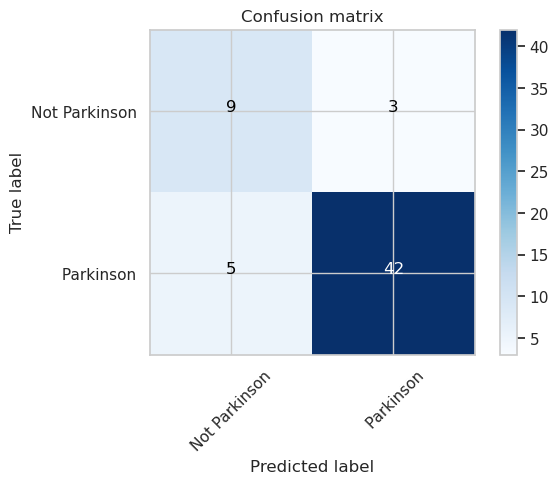

In [22]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred),classes=[ "Not Parkinson", " Parkinson"],title='Confusion matrix')

In [23]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.75      0.69        12
           1       0.93      0.89      0.91        47

    accuracy                           0.86        59
   macro avg       0.79      0.82      0.80        59
weighted avg       0.87      0.86      0.87        59


Accuracy Score: 0.864406779661017


Grid Search CV

In [24]:
param_grid = {'n_neighbors': [3, 5, 7, 9]}

In [25]:
#define the KNN classifier object
knn = KNeighborsClassifier()

Grid Search

In [26]:
from sklearn.model_selection import GridSearchCV


grid_search = GridSearchCV(knn, param_grid, scoring='recall', cv=5)

grid_search 

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='recall')

In [27]:
#training data
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [3, 5, 7, 9]}, scoring='recall')

In [28]:
#Validation

print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'n_neighbors': 9}
Best Score:  0.97


In [29]:
#Getting predicted Labels
y_pred = grid_search.best_estimator_.predict(X_test)

calculating recall score

In [30]:
from sklearn.metrics import recall_score
recall = recall_score(y_test, y_pred)

recall

0.9148936170212766

In [31]:
y_hat = grid_search.best_estimator_.predict(X)

Training the Model

In [32]:
knn = KNeighborsClassifier()
knn.fit(X,y)

KNeighborsClassifier()

In [33]:
y_hat =knn.predict(X)

plotting confusion matrix

Confusion matrix, without normalization
[[ 32  16]
 [  5 142]]


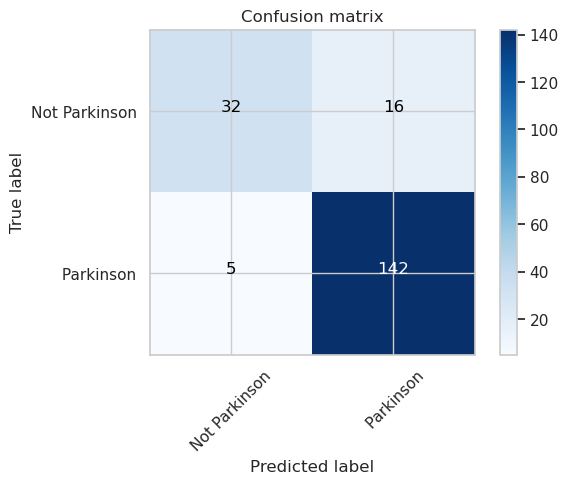

In [34]:
plot_confusion_matrix(confusion_matrix(y, y_hat),classes=[ "Not Parkinson", " Parkinson"],title='Confusion matrix')

Machine Learning Interpretability

In [35]:
# find true positives(tp)
tsne_df['label']=''
tsne_df['label'].iloc[np.where((y_hat == 1) & (y == 1))]="TP"
# find true negatives (tn)
tsne_df['label'].iloc[np.where((y_hat == 0) & (y == 0))]="TN"
# find false positives (fp)
tsne_df['label'].iloc[np.where((y_hat == 1) & (y == 0))]="FP" 
# find false negatives (fp)
tsne_df['label'].iloc[np.where((y_hat == 0) & (y == 1))]="FN"

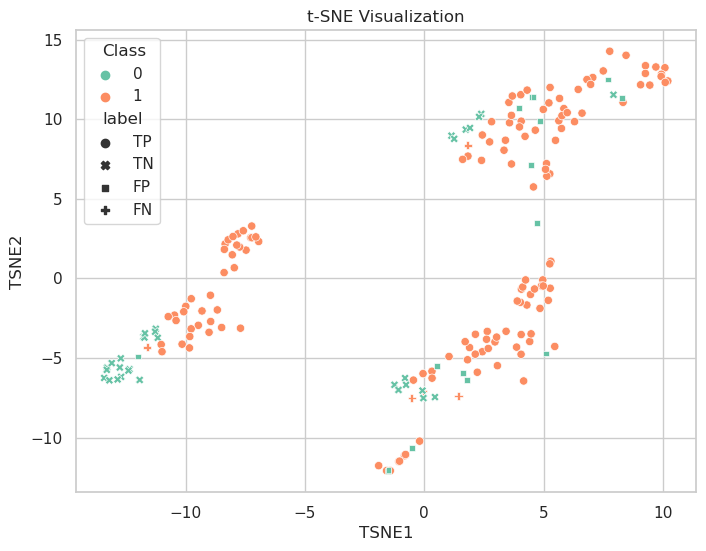

In [36]:
#plot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=tsne_df, x='TSNE1', y='TSNE2', hue='Class', palette='Set2',style='label')
plt.title('t-SNE Visualization')
plt.show()

Logistic Regression

In [37]:
from sklearn.linear_model import LogisticRegression

In [38]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [39]:
y_pred = lr.predict(X_test)
y_pred[0:10]

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 0])

Confusion matrix, without normalization
[[ 9  3]
 [ 6 41]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.93      0.87      0.90        47

    accuracy                           0.85        59
   macro avg       0.77      0.81      0.78        59
weighted avg       0.86      0.85      0.85        59


Accuracy Score: 0.847457627118644


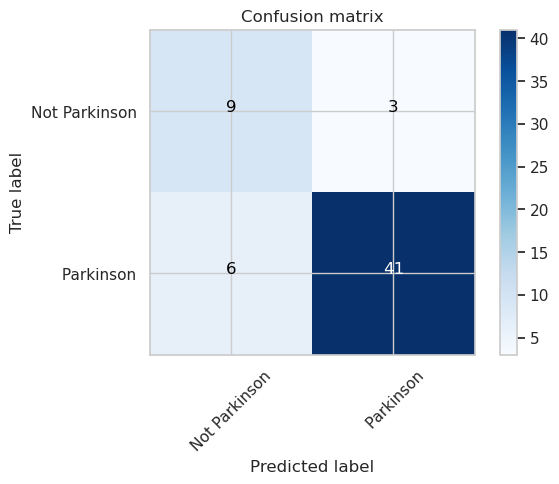

In [40]:
#plotting confusion matrix
plot_confusion_matrix(confusion_matrix(y_test, y_pred),classes=[ "Not Parkinson", " Parkinson"],title='Confusion matrix')
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

obtaining the coefficients

In [41]:
coef=abs(lr.coef_[0])

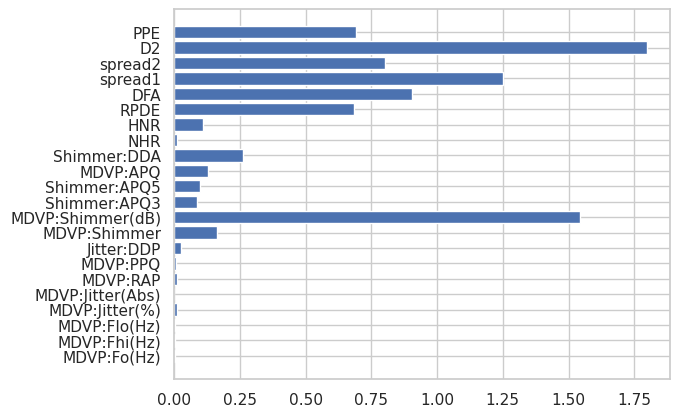

In [42]:
plt.barh(X.columns, coef)
plt.show()

In [43]:
best_columns=X.columns[np.argsort(-1*coef)[0:5]]
best_columns

Index(['D2', 'MDVP:Shimmer(dB)', 'spread1', 'DFA', 'spread2'], dtype='object')

Confusion matrix, without normalization
[[ 9  3]
 [ 6 41]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.75      0.67        12
           1       0.93      0.87      0.90        47

    accuracy                           0.85        59
   macro avg       0.77      0.81      0.78        59
weighted avg       0.86      0.85      0.85        59


Accuracy Score: 0.847457627118644


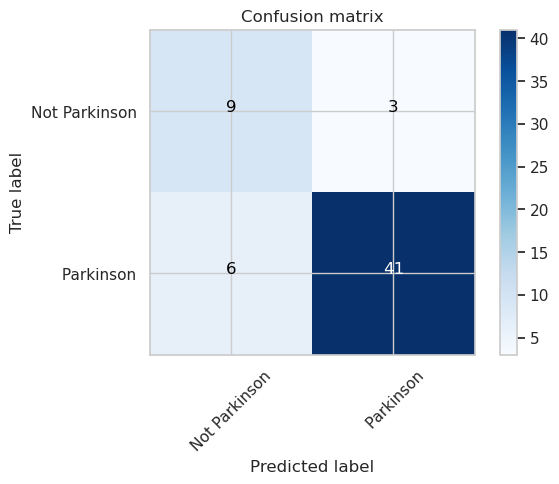

In [44]:
log_reg = LogisticRegression(max_iter=10000)
log_reg.fit(X_train[best_columns], y_train)

# Get the predicted probabilities for each class
y_pred_proba = log_reg.predict_proba(X_test[best_columns])

plot_confusion_matrix(confusion_matrix(y_test, y_pred),classes=[ "Not Parkinson", " Parkinson"],title='Confusion matrix')
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nAccuracy Score:", accuracy_score(y_test, y_pred))

# SVM Model

Confusion matrix, without normalization
[[ 4  8]
 [ 2 45]]


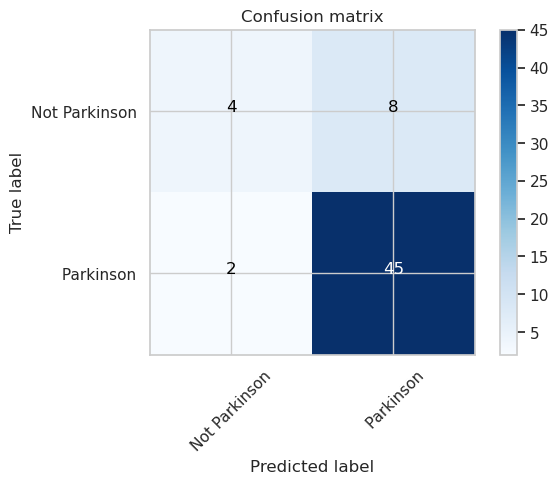

In [48]:
from sklearn.svm import SVC

# Train the SVM classifier
svm = SVC()
svm.fit(X_train, y_train)

# Make predictions on the test set
y_hat = svm.predict(X_test)

# confusion_matrix
plot_confusion_matrix(confusion_matrix(y_test, y_hat),classes=[ "Not Parkinson", " Parkinson"],title='Confusion matrix')

In [50]:
param_grid = {'C': [0.1, 1,],'gamma': [0.1, 1, 10]}


Grid Search

In [51]:
# Train the SVM classifier
svm = SVC()
# Create a GridSearchCV object
grid_search = GridSearchCV(svm, param_grid, scoring='recall', cv=2)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and the corresponding recall score
print("Best hyperparameters: ", grid_search.best_params_)
print("Best recall score: ", grid_search.best_score_)

Best hyperparameters:  {'C': 0.1, 'gamma': 0.1}
Best recall score:  1.0


# Random Forest Model

In [55]:
from sklearn.ensemble import RandomForestClassifier
# Create a Random Forest model
rf = RandomForestClassifier(random_state=123)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2f}%".format(accuracy * 100))

Accuracy: 89.83%


Grid Search

In [56]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [5, 10, 15],
    'max_features': ['sqrt', 'log2']
}

# Create a random forest classifier
rf = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to the data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best parameters:", grid_search.best_params_)

# Get the best model
best_model = grid_search.best_estimator_

Best parameters: {'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 100}


<AxesSubplot:>

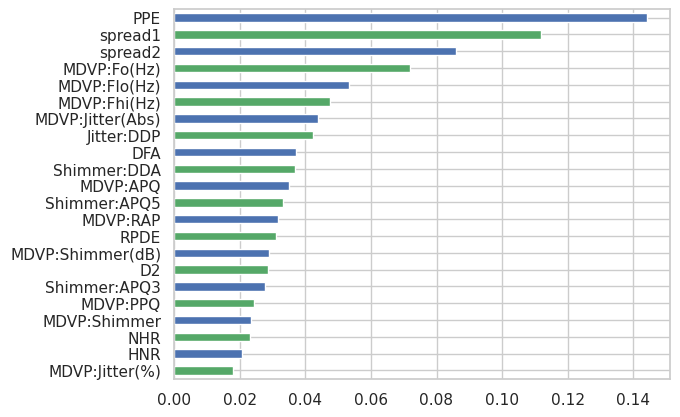

In [58]:
# Train the RandomForestClassifier
rf.fit(X_train, y_train)

# Plot the important features
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh', color=['g', 'b'])


In [59]:
#To save the trained model we utilize liberary pickle
import pickle


filename = 'rf_model_parkinson'
pickle.dump(rf, open(filename, "wb"))

# Visualizing the Decision Trees

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

# Create a decision tree classifier
dt = DecisionTreeClassifier()

# Use GridSearchCV to search for the best parameters
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best recall score:", grid_search.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best recall score: 0.8746031746031745


In [61]:
clf=grid_search.best_estimator_

# Make predictions on the test data
y_pred = clf.predict(X_test)

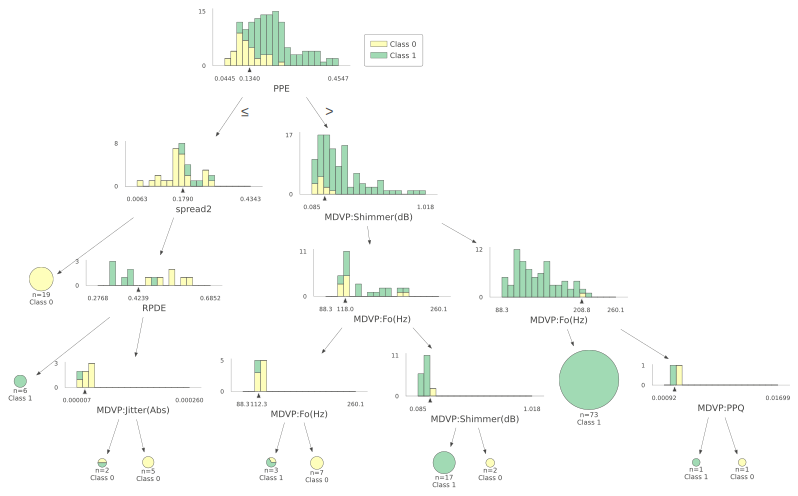

In [63]:
# plot the tree 
import dtreeviz

# Getting the list of variables
feature_names = list(X_train.columns)

# visualizing the tree
viz_model = dtreeviz.model(clf,
                           X_train=X_train, y_train=y_train, 
                           feature_names=feature_names)

v = viz_model.view(fancy=True) 
v

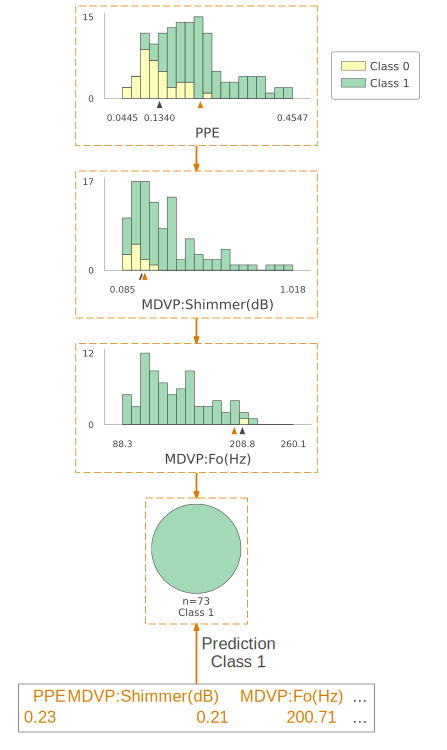

In [64]:
# get a random point
rand = np.random.randint(0, len(X))
sample_point = X.iloc[rand,:].values

# visualizing the path for the point
v = viz_model.view(fancy=True,scale=1.5,x=sample_point,show_just_path=True)
v